In [747]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = 12, 8
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.grid_search import GridSearchCV
pd.options.display.max_columns = 100

In [748]:
df=pd.read_csv("parsed_df.csv")

In [762]:
dftouse=df.copy()
dftouse=dftouse.dropna()
dftouse=dftouse.sample(50000, replace=False)
del dftouse['Unnamed: 0']
del dftouse['PLAYER_ID']

In [763]:
#drop all rows with NaN values
dftouse = dftouse.dropna()

In [764]:
cols = list(dftouse)
cols.insert(0, cols.pop(cols.index('SHOT_MADE_FLAG')))
dftouse = dftouse.ix[:, cols]
dftouse.head()

,SHOT_MADE_FLAG,EVENTNUM,PERIOD_x,SCOREMARGIN,ACTION_BEFORE,CLOSE_DEF_DIST,DRIBBLES,LOCATION,PTS_TYPE,SHOT_CLOCK,SHOT_NUMBER,TOUCH_TIME,GAME_EVENT_ID,SHOT_DISTANCE,LOC_X,LOC_Y,SEC_LEFT_Q,SEC_LEFT_G,OFF_HEIGHT,DEF_HEIGHT,HEIGHT_DIFF,JUMP_SHOT,SHOT_DISTxCLOSE_DEF_DIST,HEIGHTxCLOSE_DEF_DIST,SHOT_DISTxJUMP_SHOT
280485,0,351,3,-8,5,0.5,3,0,2,21.5,11,3.3,351,2,-21,1,224,944,78,73,5,0,1.0,2.5,0
321890,1,157,2,-15,4,2.8,0,0,2,18.1,3,0.7,157,1,15,3,516,1956,81,85,-4,0,2.8,-11.2,0
27238,0,329,3,3,2,2.9,4,0,2,10.3,7,2.8,329,7,1,77,387,1107,71,76,-5,0,20.3,-14.5,0
278081,1,354,3,-20,8,8.2,0,0,2,6.6,9,0.8,354,20,-117,167,112,832,84,85,-1,1,164.0,-8.2,20
381593,1,387,3,-2,2,3.7,0,0,2,24.0,6,0.0,387,1,-15,1,145,865,75,83,-8,0,3.7,-29.6,0


In [765]:
dftouse.shape

(50000, 25)

In [766]:
#dftouse.isnull().sum()

In [767]:
#dftouse.isnull().any()

In [768]:
Xnames = list(dftouse.columns.values[1:25])

In [775]:
#Xnames

In [770]:
#create train and test set
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [771]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    y_=indf[targetname]
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [772]:
%%time


clfForest = RandomForestClassifier()

parameters = {
    "n_estimators" : [10,50,100,500],
    #"n_estimators" : range(1, 21),
    #"max_features" : range(10,len(Xnames+1),2)
    "max_depth": [50,100,200,400],
    #"bootstrap": [True, False]
}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, dftouse, Xnames, 'SHOT_MADE_FLAG', 1, mask=mask, n_folds = 5, n_jobs = 4, score_func='f1')

using mask


/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 500, 'max_depth': 200} 0.578328120436 [mean: 0.52524, std: 0.00219, params: {'n_estimators': 10, 'max_depth': 50}, mean: 0.56280, std: 0.00261, params: {'n_estimators': 50, 'max_depth': 50}, mean: 0.57405, std: 0.00330, params: {'n_estimators': 100, 'max_depth': 50}, mean: 0.57441, std: 0.00229, params: {'n_estimators': 500, 'max_depth': 50}, mean: 0.52525, std: 0.00633, params: {'n_estimators': 10, 'max_depth': 100}, mean: 0.56388, std: 0.00571, params: {'n_estimators': 50, 'max_depth': 100}, mean: 0.57045, std: 0.00489, params: {'n_estimators': 100, 'max_depth': 100}, mean: 0.57633, std: 0.00209, params: {'n_estimators': 500, 'max_depth': 100}, mean: 0.52453, std: 0.00732, params: {'n_estimators': 10, 'max_depth': 200}, mean: 0.56453, std: 0.00227, params: {'n_estimators': 50, 'max_depth': 200}, mean: 0.57221, std: 0.00645, params: {'n_estimators': 100, 'max_depth': 200}, mean: 0.57833, std: 0.00385, params: {'n_estimators': 500, 'max_depth': 200}, mean: 0.52127

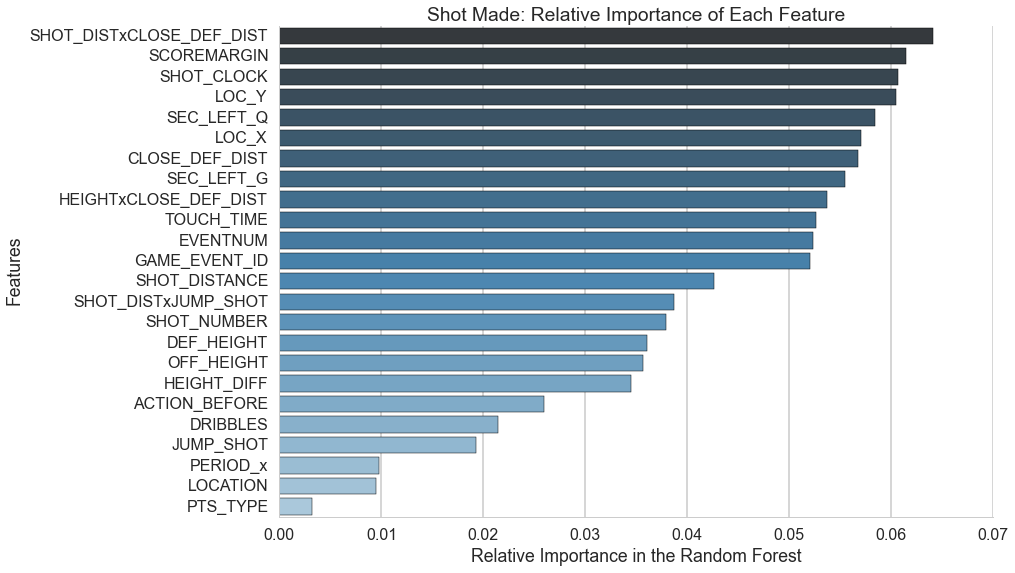

In [777]:
importance_list = clfForest.feature_importances_
name_list = dftouse.columns
importance_list, name_list = zip(*sorted(zip(importance_list, Xnames)))
ax = sns.barplot(y=range(len(name_list)),x=list(reversed(importance_list)), orient='h', palette="Blues_d")
ax.set_xlabel('Relative Importance in the Random Forest')
ax.set_ylabel('Features')
ax.set_title('Shot Made: Relative Importance of Each Feature')
ax.set_yticklabels(list(reversed(name_list)));
sns.despine()
plt.savefig('Baseline Relative Importance.png', bbox_inches='tight')